# Lab 4 - Distance Preserving Methods

This notebook introduces Distance Preserving Methods for dimension reduction, their visualization and spatial analysis.

It is part of the Spatial Cluster Analysis course taught at the University of Chicago in the Winter Quarter of 2025.

Prepared by: Luc Anselin (anselin@uchicago.edu) and Pedro Amaral (pedroamaral@uchicago.edu)

## Preliminaries
We will consider two broad classes of distance preserving methods, multi-dimensional scaling (MDS) and stochastic neighbor embedding (t-SNE). We start with considering the classic metric method for MDS, which is essentially the same as considering the two leading principal components. Whereas classic MDS is limited to Euclidean distances, the SMACOF method can be applied to any type of distance metric. t-SNE is based on a different principle, using information-theoretic concepts of the similarity between probability distributions as the criterion for embedding.

The empirical illustration replicates the examples in Chapters 3 and 4 of the Spatial Cluster book.

### Required packages

The conda enviroment used for this exercise was created from a yml file with the same specification as in the previous notebooks:

As in the treatment of PCA, we will also need **pygeoda** for some of the aspects of *spatializing* the MDS. If not already installed, the library can be installed running `pip install pygeoda` from your terminal or notebook. Preferably, use `pip install -U pygeoda` to make sure you have the latest version.

In addition to the usual numpy, pandas, geopandas and matplotlib, we also import several specialized packages from scikit-learn. Specifically, to carry out variable standardization we import `StandardScaler` from `sklearn.preprocessing`, and to compute the distance matrix we need `pairwise_distances` from `sklearn.metrics`. The specific methods are `MDS` and `TSNE` from `sklearn.manifold`, `PCA` from `sklearn.decomposition` and, as before, `HDBSCAN` from `sklearn.cluster`. Finally, to implement some of the *spatialization* of these methods, we import `KNN` and `w_interaction` from `libpysal.weights` and `cluster_stats` from the `spatial_cluster_course` utility module (this requires that the file spatial_cluster_course.py is accessible through your Python Path). In this notebook, we introduce some additional helper functions as well (specifically, `stress_value`, `distcorr` and `common_coverage`).

In [12]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import HDBSCAN

from libpysal.weights import KNN, w_intersection
from spatial_cluster_course import cluster_stats
from spatial_cluster_course import stress_value, distcorr
from spatial_cluster_course import common_coverage

import pygeoda 

### Load data

For this exercise, we will use a data set on community bank performance in Italy. This is also a GeoDa sample data set. Detailed source and information available at https://geodacenter.github.io/data-and-lab/Italy-Community-Banks/

The following files will be used:
- **italy_banks.shp,shx,dbf,prj**: shape file (four files) for 261 community bank locations (as points)

We follow the usual practice of setting a path (if needed), reading the data from the shape file and a quick check of its contents (`head`).

In [ ]:
# Setting working folder:
#path = "/your/path/to/data/"
path = ""

# Load the Italy Banks data:
dfs = gpd.read_file(path+"italy_banks/italy_banks.shp")
print(dfs.shape)
dfs.head(3)

(261, 102)


,idd,BankName,City,latitud,longitud,COORD_X,XKM,COORD_Y,YKM,ID,...,EXPE_16,EXPE_17,SERV_11,SERV_12,SERV_13,SERV_14,SERV_15,SERV_16,SERV_17,geometry
0,1.0,Banca di Andria di Credito Cooperativo SocietÃ...,ANDRIA,41.226694,16.302685,1.112303e+06,1112.303366,4.589794e+06,4589.793823,1.0,...,0.027966,0.025114,0.793877,0.775691,0.745046,0.630469,0.611941,0.640208,0.666425,POINT (1112303.366 4589793.823)
1,8.0,Banca di Credito Cooperativo di Napoli-BCC di ...,NAPLES,40.841020,14.250822,9.427720e+05,942.771983,4.534476e+06,4534.475758,8.0,...,0.023624,0.018840,0.770019,0.562623,0.540712,0.522125,0.601549,0.502599,0.625220,POINT (942771.983 4534475.758)
2,9.0,Banca Adria Credito Cooperativo del Delta s.c....,ADRIA,45.052882,12.056720,7.407057e+05,740.705695,4.993464e+06,4993.464408,9.0,...,0.013770,0.012745,0.790542,0.626628,0.515733,0.358735,0.483700,0.567946,0.608880,POINT (740705.695 4993464.408)


In [14]:
# the full set of variables
print(list(dfs.columns))

['idd', 'BankName', 'City', 'latitud', 'longitud', 'COORD_X', 'XKM', 'COORD_Y', 'YKM', 'ID', 'IDNN', 'distnn', 'REGCODE', 'PROVNAME', 'PROVCODE', 'COMCODE', 'REGNAME', 'TE_IN_11', 'TE_IN_12', 'TE_IN_13', 'TE_IN_14', 'TE_IN_15', 'TE_IN_16', 'TE_IN_17', 'TE_OUT_11', 'TE_OUT_12', 'TE_OUT_13', 'TE_OUT_14', 'TE_OUT_15', 'TE_OUT_16', 'TE_OUT_17', 'CAPRAT11', 'CAPRAT12', 'CAPRAT13', 'CAPRAT14', 'CAPRAT15', 'CAPRAT16', 'CAPRAT17', 'Z_11', 'Z_12', 'Z_13', 'Z_14', 'Z_15', 'Z_16', 'Z_17', 'LIQASS_11', 'LIQASS_12', 'LIQASS_13', 'LIQASS_14', 'LIQASS_15', 'LIQASS_16', 'LIQASS_17', 'NPL_11', 'NPL_12', 'NPL_13', 'NPL_14', 'NPL_15', 'NPL_16', 'NPL_17', 'LLP_11', 'LLP_12', 'LLP_13', 'LLP_14', 'LLP_15', 'LLP_16', 'LLP_17', 'INTR_11', 'INTR_12', 'INTR_13', 'INTR_14', 'INTR_15', 'INTR_16', 'INTR_17', 'DEPO_11', 'DEPO_12', 'DEPO_13', 'DEPO_14', 'DEPO_15', 'DEPO_16', 'DEPO_17', 'EQLN_11', 'EQLN_12', 'EQLN_13', 'EQLN_14', 'EQLN_15', 'EQLN_16', 'EQLN_17', 'EXPE_11', 'EXPE_12', 'EXPE_13', 'EXPE_14', 'EXPE_15', 

#### Selecting variables and checking their correlation

We will use a selection of bank performance indicators for 2013:

List of variables:
| Column Name  | Description                                                                             |
|--------------|-----------------------------------------------------------------------------------------|
| CAPRAT       | Ratio of capital over risk weighted assets                                             |
| Z            | Z score of return on assets (ROA) + leverage over the standard deviation of ROA        |
| LIQASS       | Ratio of liquid assets over total assets                                               |
| NPL          | Ratio of non-performing loans over total loans                                         |
| LLP          | Ratio of loan loss provision over customer loans                                       |
| INTR         | Ratio of interest expense over total funds                                             |
| DEPO         | Ratio of total deposits over total assets                                              |
| EQLN         | Ratio of total equity over customer loans                                              |
| EXPE         | Ratio of operating expenses over total assets                                          |
| SERV         | Net interest income over operating revenues                                       |

We start by computing all pairwise correlations by applying the `corr` method to the subset of the data frame that contains the selected variables. The results are rounded to two decimals.

In [16]:
varlist = ['CAPRAT13', 'Z_13', 'LIQASS_13', 'NPL_13', 'LLP_13', 
                'INTR_13', 'DEPO_13', 'EQLN_13', 'EXPE_13', 'SERV_13']

In [17]:
data_mds = dfs[varlist]

round(data_mds.corr(), 2)

,CAPRAT13,Z_13,LIQASS_13,NPL_13,LLP_13,INTR_13,DEPO_13,EQLN_13,EXPE_13,SERV_13
CAPRAT13,1.00,-0.03,0.21,-0.08,-0.10,-0.39,0.18,0.87,0.14,0.32
Z_13,-0.03,1.00,-0.08,-0.28,-0.16,-0.02,-0.15,-0.02,-0.14,-0.04
LIQASS_13,0.21,-0.08,1.00,-0.00,-0.05,-0.14,0.23,0.09,0.18,0.01
NPL_13,-0.08,-0.28,-0.00,1.00,0.64,0.33,-0.09,-0.10,0.15,-0.20
LLP_13,-0.10,-0.16,-0.05,0.64,1.00,0.41,-0.19,-0.14,-0.04,-0.39
INTR_13,-0.39,-0.02,-0.14,0.33,0.41,1.00,-0.43,-0.48,-0.18,-0.40
DEPO_13,0.18,-0.15,0.23,-0.09,-0.19,-0.43,1.00,0.18,0.16,0.17
EQLN_13,0.87,-0.02,0.09,-0.10,-0.14,-0.48,0.18,1.00,0.12,0.39
EXPE_13,0.14,-0.14,0.18,0.15,-0.04,-0.18,0.16,0.12,1.00,0.07
SERV_13,0.32,-0.04,0.01,-0.20,-0.39,-0.40,0.17,0.39,0.07,1.00


## Classic MDS

Classic MDS is based on the Gramm matrix $XX'$ when the full data set is available (as is the case here). Alternatively, it can also be computed directly from a double-centered distance matrix, which is useful when that is the only information available (i.e., no full set of observations $X$):
$XX' = - (1/2)(I - M)D^2(I - M)$,
where $M$ is a matrix consisting of elements $1 / n$. The result of the $(I - M)$ operation is compute values as deviations from the mean. Pre- and post-multiplying the squared distance matrix with $(I - M)$ is referred to as *double centering*.

We start by comparing the two matrices. As before, we first standardize the variables. In the example below, the matrix $(I - M)$ is used as $H$.

#### Equivalence Gramm matrix and double centered square distance

In [18]:
# Pre-processing: standardize the data
X = StandardScaler().fit_transform(data_mds)

# Compute pairwise distances
dist_matrix = pairwise_distances(X)

# Double-center the distance matrix
n_samples = dist_matrix.shape[0]
H = np.eye(n_samples) - np.ones((n_samples, n_samples)) / n_samples
B = -0.5 * H @ (dist_matrix ** 2) @ H

# Compare to XX
XXp = X @ X.T

print("B",B[0:5,0:5])
print("XXp",XXp[0:5,0:5])

B [[ 2.07700836e+01  1.19850381e+01 -3.04437191e-01 -4.46754435e+00
  -6.75815062e+00]
 [ 1.19850381e+01  1.71772980e+01  4.22260221e+00 -1.76067198e-02
  -1.91990000e+00]
 [-3.04437191e-01  4.22260221e+00  7.49594112e+00  4.04560929e+00
   4.20339927e+00]
 [-4.46754435e+00 -1.76067198e-02  4.04560929e+00  7.39569901e+00
   5.11760413e+00]
 [-6.75815062e+00 -1.91990000e+00  4.20339927e+00  5.11760413e+00
   6.73823232e+00]]
XXp [[ 2.07700836e+01  1.19850381e+01 -3.04437191e-01 -4.46754435e+00
  -6.75815062e+00]
 [ 1.19850381e+01  1.71772980e+01  4.22260221e+00 -1.76067198e-02
  -1.91990000e+00]
 [-3.04437191e-01  4.22260221e+00  7.49594112e+00  4.04560929e+00
   4.20339927e+00]
 [-4.46754435e+00 -1.76067198e-02  4.04560929e+00  7.39569901e+00
   5.11760413e+00]
 [-6.75815062e+00 -1.91990000e+00  4.20339927e+00  5.11760413e+00
   6.73823232e+00]]


Clearly, it doesn't matter whether we use the Gramm matrix or the double centered squared distance matrix. In our example, since we have the full matrix $X$, we will use the former to compute the eigenvalues and eigenvectors.

#### Eigendecomposition

We use the `eigh` function from `numpy.linalg` because we know that $XX'$ is real and symmetric. Note that the eigenvalues are not necessarily in order, so that we need to apply `argsort` to get them in decreasing order. 

In [19]:
# Eigendecomposition
eigvals, eigvecs = np.linalg.eigh(XXp)
sorted_indices = np.argsort(eigvals)[::-1]
eigvals = eigvals[sorted_indices]
eigvecs = eigvecs[:, sorted_indices]

print("Leading eigenvalues",eigvals[0:2])

Leading eigenvalues [779.54044692 460.18913726]


#### MDS dimensions

We construct the first two dimensions as $VG^{1/2}$, i.e., we multiply the first two eigenvectors with the square root of the matching eigenvalue. We add the result to a data frame for easy plotting.

In [20]:
# Compute the embedding
k = 2  # Number of dimensions
top_eigvals = eigvals[:k]
top_eigvecs = eigvecs[:, :k]
embedding = top_eigvecs * np.sqrt(top_eigvals)
mds_classic_df = pd.DataFrame(embedding, columns=['Dimension 1', 'Dimension 2'])
print(mds_classic_df.head(10))

   Dimension 1  Dimension 2
0    -2.266790     0.434138
1    -1.179120     1.977893
2     1.519542     0.677415
3     2.319006     0.928530
4     2.369562    -0.240218
5    -2.548597    -0.089174
6     3.475160     3.461779
7     0.214755    -0.683837
8     0.273706     1.325170
9     1.427797     0.922841


#### Stress function

A measure of how well the higher-dimension distances have been reflected in the embedding is given by the stress function, the squared difference between the pairwise distances in higher dimension and in the embedded space.

To compute the stress value, we need the `pairwise_distance` for the embedded coordinates. We then compute the sum of squares of the differences between the two distances (raw stress), and normalize this by dividing by the sum of squares of the original distance matrix. This is implemented in the `stress_value` function imported from the `spatial_cluster_course` module.

In [21]:
r1, nr1 = stress_value(dist_matrix,embedding)
print(f"Raw Stress: {np.round(r1,4)}")
print(f"Normalized Stress: {np.round(nr1,4)}")

Raw Stress: 105792.7325
Normalized Stress: 0.3941


Note how the stress value is identical to the measure shown in Figure 3.3. of the Spatial Clustering book.

#### Rank correlation

Another common measure to indicate the quality of the MDS embedding is a rank correlation between the two distance matrices. The small function `distcorr` from the `spatial_cluster_course` module computes the Spearman rank correlation using the `spearmanr` function from `scipy.stats`. To avoid duplication, we first extract the upper diagonal elements from each distance matrix and turn them into a numpy array. We then compute the rank correlation between the two arrays. The result of 0.804 is again identical to the result shown in Figure 3.3 of the Spatial Clustering book.

In [22]:
print("Rank correlation: ",distcorr(dist_matrix,embedding))

Rank correlation:  0.8036518791116136


#### Visualizing MDS results

We illustrate the locations in the two-dimensional MDS space by means of a simple scatter plot applied to the dimension coordinates contained in the mds_classic_df data frame.

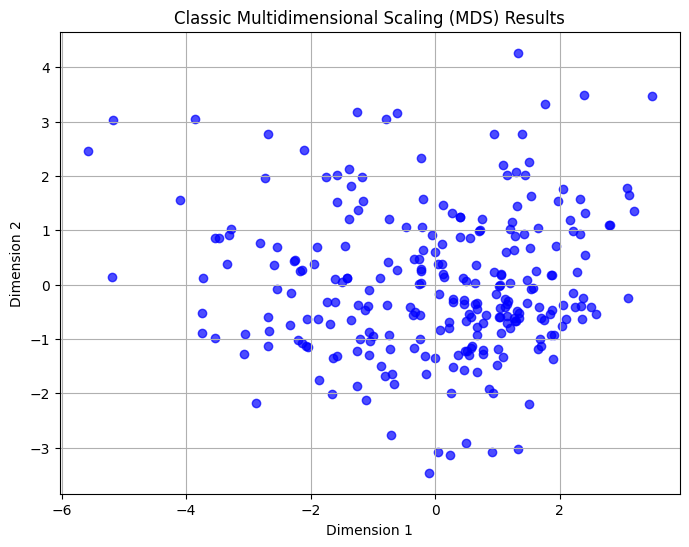

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(mds_classic_df['Dimension 1'], mds_classic_df['Dimension 2'], color='blue', alpha=0.7)
plt.title('Classic Multidimensional Scaling (MDS) Results')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

## Classic MDS and PCA

Since the Classic MDS solution is based on the eigenvalues and eigenvectors of $XX'$, the dimensions provide the same information as the principal components. We can illustrate this by showing the associated scatter plots side by side, as well as by means of a scatterplot of the first PCA and the first MDS dimension. These are shown below. 

We compute the principal components using the PCA class from scikit learn, as illustrated in the previous notebook. The example basically manipulates the columns of the respective data frames in the plotting routines.

The resulting plots are identical.

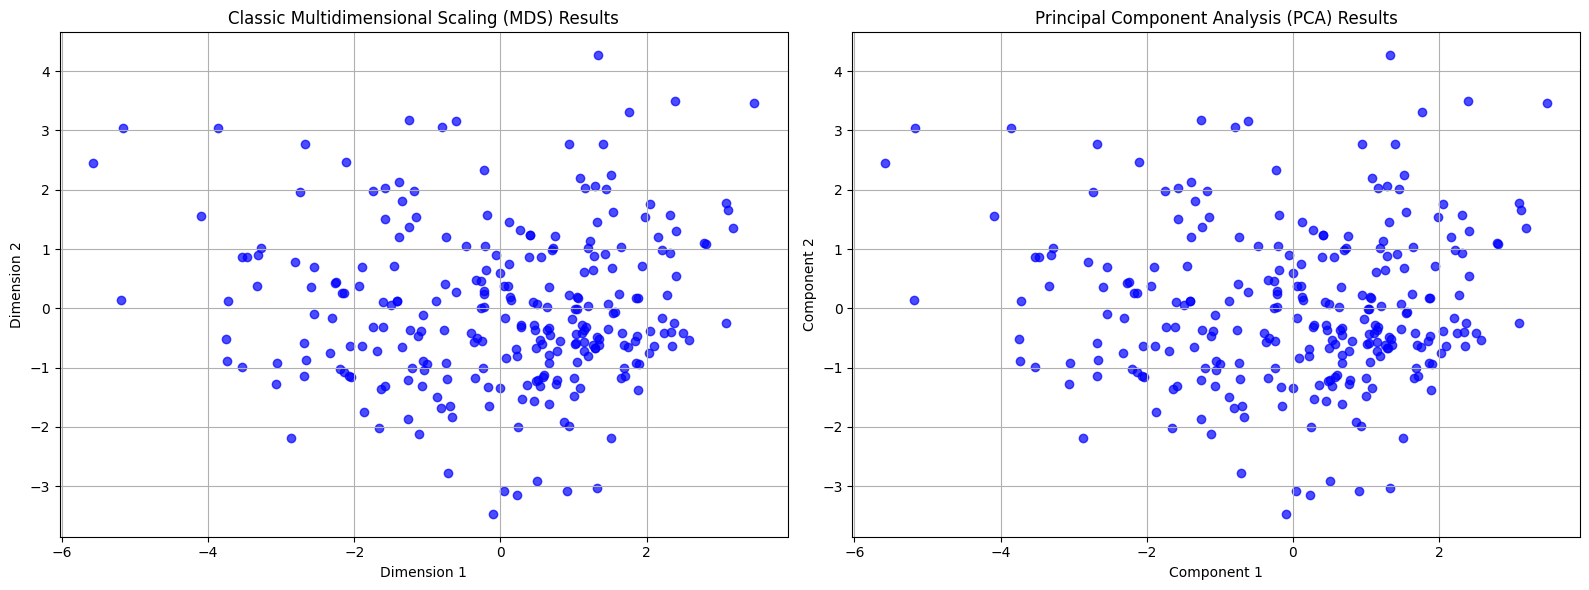

In [24]:
#Compare with PCA
pca_res = PCA(n_components=2).fit_transform(X)

pca_df = pd.DataFrame(pca_res[:, :2], columns=['Component 1', 'Component 2'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Create a figure with 1 row and 2 columns

# Plot MDS results
axes[0].scatter(mds_classic_df['Dimension 1'], mds_classic_df['Dimension 2'], color='blue', alpha=0.7)
axes[0].set_title('Classic Multidimensional Scaling (MDS) Results')
axes[0].set_xlabel('Dimension 1')
axes[0].set_ylabel('Dimension 2')
axes[0].grid(True)

# Plot PCA results
axes[1].scatter(pca_df['Component 1'], pca_df['Component 2'], color='blue', alpha=0.7)
axes[1].set_title('Principal Component Analysis (PCA) Results')
axes[1].set_xlabel('Component 1')
axes[1].set_ylabel('Component 2')
axes[1].grid(True)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

Finally, we show a scatter plot of the first principal component against the first MDS dimension. We extract these from their respective data frames, i.e, the just created `pca_df` and `mds_classic_df`. We carry out some utility manipulations to create a nice graph. The result shows a perfect linear relationship between the two concepts.

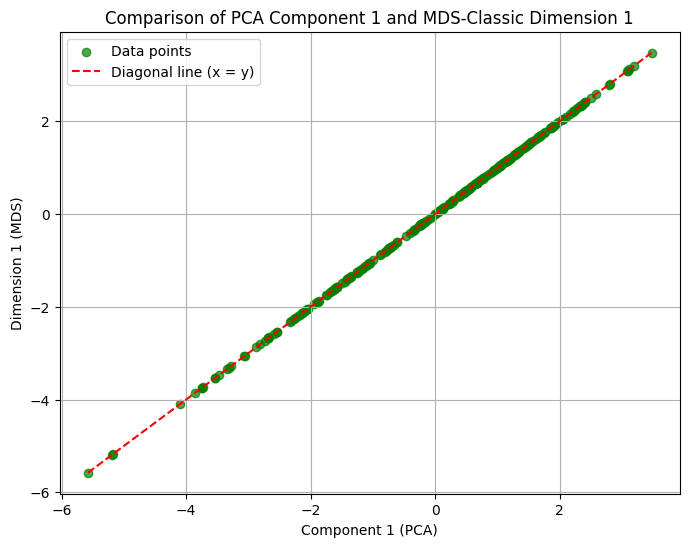

In [25]:
# Combine MDS and PCA results into one DataFrame
comparison_df = pd.DataFrame({
    'Component 1': pca_df['Component 1'],
    'Dimension 1': mds_classic_df['Dimension 1']
})

# Get the range for the axes
x_min, x_max = comparison_df['Component 1'].min(), comparison_df['Component 1'].max()
y_min, y_max = comparison_df['Dimension 1'].min(), comparison_df['Dimension 1'].max()

# Determine the limits for the diagonal line (x = y)
min_val = min(x_min, y_max)  # Smallest value considering the inverted y
max_val = max(x_max, y_min)  # Largest value considering the inverted y

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(comparison_df['Component 1'], comparison_df['Dimension 1'], color='green', alpha=0.7, label='Data points')
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Diagonal line (x = y)')  # Line for x = -y
plt.title('Comparison of PCA Component 1 and MDS-Classic Dimension 1')
plt.xlabel('Component 1 (PCA)')
plt.ylabel('Dimension 1 (MDS)')
plt.grid(True)
plt.legend()
plt.show()


## MDS using SMACOF with scikit-learn 

#### Computing the SMACOF solution

The `MDS` class in `sklearn.manifold` implements the SMACOF method to find coordinates in embedded space. The implementation works as all others in scikit-learn: first an object of the proper class is created and then a method of the class (typically `fit`) is applied to find a solution.

There are two basic ways to accomplish this with an object of the MDS class. One is to apply the `fit_transform` method, to which the standardized $X$ matrix is passed. This yields a n x 2 numpy array with the embedded coordinates. A second, more comprehensive approach is to apply the generic `fit` method. This yields an object that contains several characteristics of the solution as attributes, such as the coordinates in `embedding_` (don't forget the underscore), the stress value in `stress_` and the number of iterations in `n_iter`. One attribute is `dissimilarity_matrix_`, the distance matrix for the original data - note that this is NOT the distance matrix for the MDS solution. For `metric` distance, the stress value is not normalized. We can use the `stress_value` function from the `spatial_cluster_course` module to compute the normalized measure.

The stress is the only measure of fit provided by the `MDS` class. To compute a rank correlation, we can use our `distcorr` function.

The `MDS` call takes as arguments the number of desired components, `n_components` - default 2 -, the type of distance, `metric = True` by default, a random number seed to ensure reproducibility, `random_state`, as well as some other arguments. In most cases the default settings are fine and only the `random_state` should be set to get the same results each time (the initialization is random, so that different results can be obtained depending on the starting values). Full details are given at https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html.

We first create an MDS object and then apply `fit_transform` to return a n by 2 array of embedded coordinates. We then turn that array into a data frame. The only argument needed is `random_state`. For all the others, the defaults are fine (e.g., `n_components = 2`).

In [26]:
# Perform MDS using scikit-learn
mds_est = MDS(random_state=42)
mds_res = mds_est.fit_transform(X)

mds_df = pd.DataFrame(mds_res, columns=['Dimension 1', 'Dimension 2'])
print(mds_df.head(10))

   Dimension 1  Dimension 2
0    -4.149542     1.796895
1    -4.251544    -0.202228
2    -0.622354    -2.438990
3     0.378048    -2.760516
4     1.543142    -2.218457
5    -4.851714     3.019239
6    -1.668119    -5.293308
7     0.912264     0.237662
8    -2.993431    -1.526119
9     0.771745    -2.507660


By using the `fit_transform` method several attributes were added to the original mds_est object. This is in addition to returning an array with coordinates. For example, the same coordinates are contained in `mds_est.embedding_`.

In [27]:
mds_est.embedding_[0:10,:]

array([[-4.14954209,  1.7968953 ],
       [-4.25154367, -0.20222757],
       [-0.62235368, -2.43898989],
       [ 0.37804812, -2.7605158 ],
       [ 1.54314207, -2.2184574 ],
       [-4.85171353,  3.01923923],
       [-1.66811892, -5.29330797],
       [ 0.91226446,  0.23766155],
       [-2.99343138, -1.52611923],
       [ 0.77174495, -2.50765995]])

If the method `fit` were used, the output would be an MDS object with the attributes attached, but not a numpy array. Otherwise, there is no distinction between the two approaches.

#### Visualizing the embedded space

As in the case of classic MDS, we can use the columns in the new data frame to create a scatter plot of the coordinates, by means of the usual matplotlib commands.

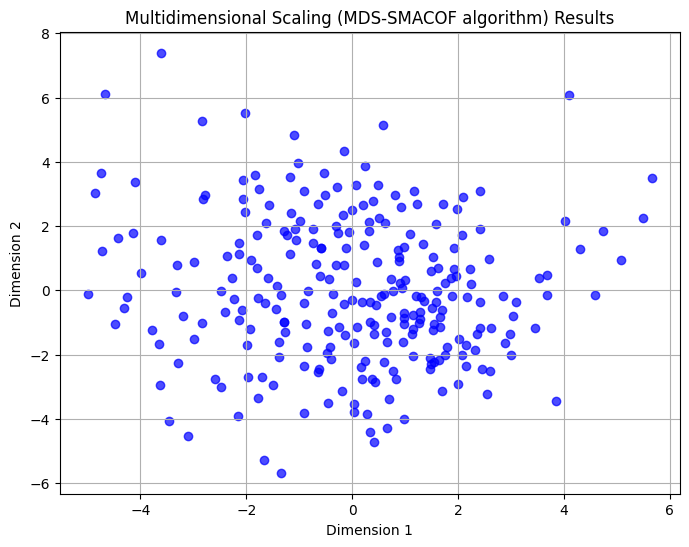

In [28]:
plt.figure(figsize=(8, 6))
plt.scatter(mds_df['Dimension 1'], mds_df['Dimension 2'], color='blue', alpha=0.7)
plt.title('Multidimensional Scaling (MDS-SMACOF algorithm) Results')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

#### Measures of fit

The MDS object contains a stress measure in the `stress_` attribute. However, for metric scaling, this result is not normalized. Also, there is no rank correlation. As mentioned, we can use the `stress_value` and `dist_corr` functions. 

In [29]:
print(mds_est.stress_)

37247.07680458296


In [30]:
r2, nr2 = stress_value(dist_matrix,mds_res)
print(f"Raw Stress: {np.round(r2,4)}")
print(f"Normalized Stress: {np.round(nr2,4)}")

Raw Stress: 37246.5319
Normalized Stress: 0.2338


In [31]:
print("Rank correlation: ",distcorr(dist_matrix,mds_res))

Rank correlation:  0.8810621644141498


#### SMACOF vs classic MDS

To compare the layout obtained by SMACOF MDS to the one from classic MDS, we take the relevant columns from the `mds_df` (for SMACOF) and `mds_classic_df` (for classic MDS) dataframes and apply the familiar matplotlib commands to set the plots side by side.

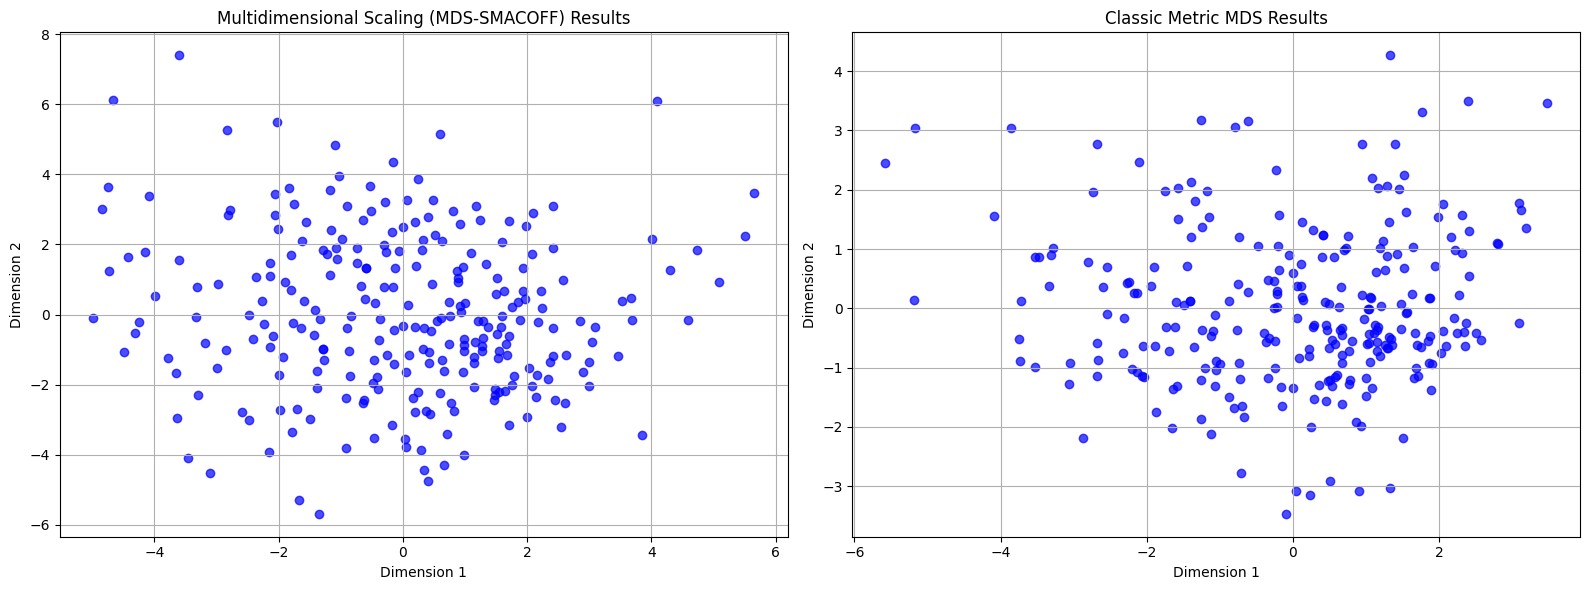

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Create a figure with 1 row and 2 columns

# Plot MDS SMACOFF results
axes[0].scatter(mds_df['Dimension 1'], mds_df['Dimension 2'], color='blue', alpha=0.7)
axes[0].set_title('Multidimensional Scaling (MDS-SMACOFF) Results')
axes[0].set_xlabel('Dimension 1')
axes[0].set_ylabel('Dimension 2')
axes[0].grid(True)

# Plot Classic MDS results
axes[1].scatter(mds_classic_df['Dimension 1'], mds_classic_df['Dimension 2'], color='blue', alpha=0.7)
axes[1].set_title('Classic Metric MDS Results')
axes[1].set_xlabel('Dimension 1')
axes[1].set_ylabel('Dimension 2')
axes[1].grid(True)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

The scatter plots reveal quite a bit of discrepancies. A more precise assessment can be found as before, in a scatter plot of the first dimension obtained for each MDS approach. The setup is the same as above, but now the relevant columns are from `mds_df` and `mds_classic_df`.

The graph clearly illustrates how the two methods result in different lower-dimensional embeddings.

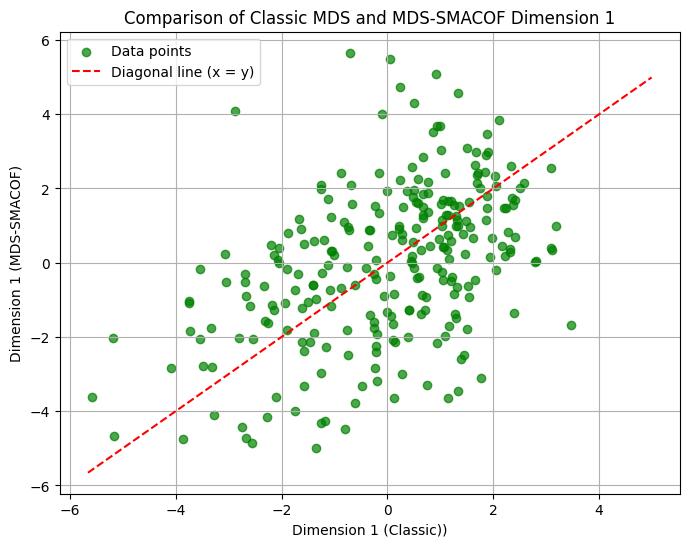

In [33]:
# Combine MDS classic and SMACOF results into one DataFrame
comparison_df = pd.DataFrame({
    'Dimension 1C': mds_classic_df['Dimension 1'],
    'Dimension 1S': mds_df['Dimension 1']
})

# Get the range for the axes
x_min, x_max = comparison_df['Dimension 1C'].min(), comparison_df['Dimension 1C'].max()
y_min, y_max = comparison_df['Dimension 1S'].min(), comparison_df['Dimension 1S'].max()

# Determine the limits for the diagonal line (x = -y)
min_val = min(x_min, -y_max)  # Smallest value considering the inverted y
max_val = max(x_max, -y_min)  # Largest value considering the inverted y

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(comparison_df['Dimension 1C'], comparison_df['Dimension 1S'], color='green', alpha=0.7, label='Data points')
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Diagonal line (x = y)')  # Line for x = -y
plt.title('Comparison of Classic MDS and MDS-SMACOF Dimension 1')
plt.xlabel('Dimension 1 (Classic))')
plt.ylabel('Dimension 1 (MDS-SMACOF)')
plt.grid(True)
plt.legend()
plt.show()


## Spatializing MDS

A distinctive characteristics of the presentation of dimension reduction methods in the Spatial Clustering book is the introduction of different ways to *spatialize* the results of an MDS. This exploits the coordinates of the points in the embedded space as a shortcut for points in higher-dimensional space. In other words, clustering on the MDS points becomes a proxy for multi-dimensional clustering.

This is particularly relevant for multivariate *spatial* clustering which we have seen is a challenge. Instead of tackling this as a multivariate problem, it is approaches as an application of two-dimensional clustering.

We consider two specific applications: a neighbor match test and HDBScan, both computed with the MDS coordinates as variables.

#### Neighbor match test

One straightforward application is the computation of a *neighbor match test* on the MDS coordinates. In our current example, this can then be compared to the results of a neighbor match test in 10-dimensional space. As mentioned, it becomes computationally quite challenging to obtain k-nearest neighbors in higher-dimensional spaces, to this provides an easy proxy.

We compute the neighbor match test by means of `pygeoda.neighbor_match_test`, as covered in a previous notebook. We first create a new data frame as a concatenation of the original point data with the coordinates from classic MDS, contained in `mds_classic_df`. We set k=12 and plot the resulting neighbor cardinality. These results can then be compared to a neighbor match test applied to the original 10 variables (not shown here).

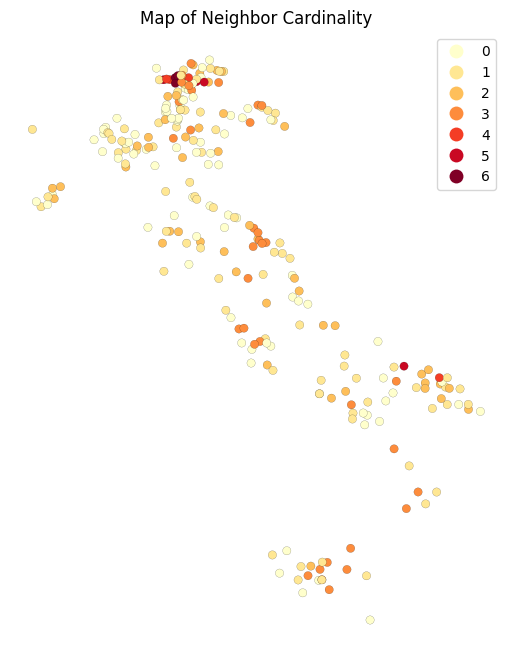

In [34]:
#Neighbor Match Test
dfs_mds = pd.concat([dfs.reset_index(drop=True), mds_classic_df.reset_index(drop=True)], axis=1)
dfs_mds_g = pygeoda.open(dfs_mds)
nmt = pygeoda.neighbor_match_test(dfs_mds_g, dfs_mds_g[['Dimension 1', 'Dimension 2']], 12)

dfs_mds['Cardinality'] = nmt['Cardinality']

fig, ax = plt.subplots(figsize=(8, 8))

dfs_mds.plot(column='Cardinality', 
              ax=ax, 
              legend=True, 
              categorical=True, 
              cmap='YlOrRd', 
              edgecolor='black',
              linewidth=0.1)  

ax.set_title("Map of Neighbor Cardinality")
ax.set_axis_off()

We observe that there are several locations (banks) with considerable overlap between the neighbors in attribute space and the geographical neighbors. These represent multivariate spatial clusters.

#### HDBScan

Another alternative to a full multidimensional clustering exercise is to carry out density-based clustering on the MDS coordinate points. In other words, close points in MDS space represent close points in the higher-dimensional attribute space. Clusters in the MDS points detected by a method such as HDBScan thus become a proxy for full multivariate clustering.

We illustrate this with the `HDBSCAN` approach from scikit learn (see a previous notebook for details). We set `min_cluster_size` to 7 and extract the dimensions from the `dfs_mds` data frame. We then map the cluster points in the usual way.

We also use the `cluster_stats` function imported from the `spatial_cluster_course` module to provide a succint summary of the cluster results. We pass the `labels_` array to this function (see a previous notebook for details).

Estimated number of clusters: 2
Estimated number of noise points: 54


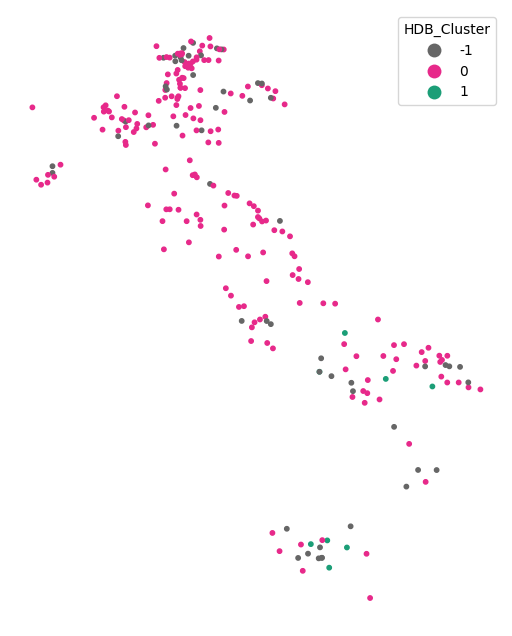

In [35]:
#HDBSCAN
hdb_results = HDBSCAN(min_cluster_size=7).fit(dfs_mds[['Dimension 1', 'Dimension 2']])

hdb_labels = [str(label) for label in hdb_results.labels_]

n_clusters_ = len(set(hdb_labels)) - (1 if '-1' in hdb_labels else 0)

n_noise_ = hdb_labels.count('-1')

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

dfs_mds['hdb_cluster'] = hdb_labels
fig, ax = plt.subplots(figsize=(8, 8))
dfs_mds.plot(column='hdb_cluster', ax=ax, cmap='Dark2_r', legend=True, markersize=10, 
              legend_kwds={'loc': 'upper right', 'title': 'HDB_Cluster'})
ax.set_axis_off()
plt.show()

In [36]:
print(cluster_stats(hdb_results.labels_))

   Labels  Cardinality
0      -1           54
1       0          199
2       1            8


## Common Coverage Percentage

The Spatial Clustering book introduces the *common coverage percentage* as a measure to quantify the extent of *local* overlap between MDS solutions. This is based on a comparison of k-nearest neighbor *spatial weights* constructed from the respective coordinates. A special case is to compare the MDS solution to geographical spatial weights, similar in spirit to the principle behind the nearest neighbor match test.

A number of different applications are possible. First, one can assess the *intersection* between two spatial weights and the extent to which this matches the overall coverage. For example, if the weights are k-nearest neighbor with k=6, then the number of non-zero elements in the weights matrix is $n_{max} = n \times k$. We can use the `w_intersection` method from `libpysal.weights` to find the number of common non-zero elements between the two spatial weights as the `nonzero` attribute of the intersection, say $n_{nonzero}$. Then the ratio of $n_{nonzero} / n_{max}$ or $n_{nonzero} / n^2$ gives a scale-free measure of the *common coverage* between the two weights. This is a quantitative measure of the commonality of nearest neighbors between the two sets of coordinates, which is easier to interpret than a visual assessment of the two scatter plots.

We first illustrate the measures for the classic MDS solution relative to the geographical k-nearest neighbors and then extend this to comparing the classic and SMACOF solutions. After going through the steps in detail, we can also import the `common_coverage` function from the `spatial_cluster_course` module so that this can be applied to any pair of weights.

The first step is to create spatial weights objects from the geographical coordinates, using `libpysal.weights.KNN.from_dataframe` and from the embedded coordinates, using `libpysal.weights.KNN.from_array` (the coordinates are passed as a $n \times 2$ numpy array). We show the number of `nonzero` cells.

In [37]:
# knn spatial weights for geographical coordinates
w_pts = KNN.from_dataframe(dfs,k=6)
print("Nonzero weights - geographical coordinates: ",w_pts.nonzero)
w_mds_classic = KNN.from_array(embedding,k=6)
w_mds_classic.nonzero
print("Nonzero weights - MDS: ",w_mds_classic.nonzero)

Nonzero weights - geographical coordinates:  1566
Nonzero weights - MDS:  1566


Of course, the non-zero weights is nothing but $n \times k$, or 261 x 6. The *density* of these weights can be compared to a complete coverage (ignoring the diagonals, taking $n^2$ for simplicity) as the ratio nonzero/$n^2$.

In this example, this yields about 2.3%.

In [38]:
n = embedding.shape[0]
(100.0 * w_pts.nonzero) / n**2

2.2988505747126435

The intersection between the two weights is obtained with the `w_intersection` method from `libpysal.weights`. We can then take the ratio of the non-zero elements to the complete coverage or to the maximum obtained for the specific value of k.

In [39]:
w_mds_knn = w_intersection(w_mds_classic,w_pts)
nn_mds = w_mds_knn.nonzero
print("Nonzero elements in intersection ",nn_mds)
print("Absolute common coverage (percent)",100.0*nn_mds/n**2)
print("Relative common coverage (percent) ",100.0*nn_mds/w_pts.nonzero)

Nonzero elements in intersection  97
Absolute common coverage (percent) 0.1423936818308598
Relative common coverage (percent)  6.194125159642401


/opt/anaconda3/envs/py312/lib/python3.12/site-packages/libpysal/weights/set_operations.py:150: UserWarning: The weights matrix is not fully connected: 
 There are 199 disconnected components.
 There are 184 islands with ids: 0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 29, 30, 31, 32, 33, 34, 36, 38, 40, 41, 42, 43, 44, 46, 48, 49, 50, 52, 53, 56, 57, 58, 59, 62, 63, 64, 68, 69, 70, 72, 73, 75, 78, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 99, 101, 105, 106, 108, 110, 112, 115, 116, 117, 118, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 152, 153, 154, 155, 156, 157, 159, 163, 164, 165, 166, 170, 172, 173, 174, 176, 178, 179, 181, 182, 185, 186, 189, 191, 192, 193, 194, 195, 196, 198, 199, 200, 201, 204, 206, 207, 210, 211, 212, 214, 215, 216, 219, 220, 221, 222, 223, 224, 225, 227, 228, 230, 231, 232, 233, 235, 236, 237, 238, 239, 240, 242, 243,

The intersection operation yields some warnings for unconnected observations, which can be safely ignored in this context. The results show 97 overlapping non-zero weights, which yield an absolute common coverage percent (relative to the complete connection) of 0.14% and a relative common coverage percent of 6.19%.

Recomputing the common coverage percentage between the point pattern and classic MDS by means of the `common_coverage` function from the `spatial_cluster_course` module.

In [40]:
comm_pt_classic = common_coverage(dfs,embedding,k=6)
print(comm_pt_classic)

(97, 0.1423936818308598, 6.194125159642401)


The common coverage percentage between classic MDS and MDS SMACOF.

In [42]:
comm_class_smac = common_coverage(embedding,mds_res)
print(comm_class_smac)

(623, 0.9145491111404707, 39.782886334610474)


Relative to the match between the geographic coordinates and MDS, the two MDS solutions show 39.8% overlap in their non-zero intersections.

## Stochastic Neighbor Embedding (SNE)

Stochastic Neighbor Embedding (SNE or t-SNE) is implemented as the class `TSNE` in `sklearn.manifold`. This operates in the same way as `MDS`. However, the results of `TSNE` are very sensitive to various parameter settings, so that just using the defaults is typically not satisfactory. Important arguments in the creation of an object of class `SNE` are:
- `n_components`: the dimension of the embedding, default = 2
- `perplexity`: a measure of the number of nearest neighbors considered, related to the entropy of the distribution, default = 30.0
- `learning_rate`: multiplier used in the optimization routine, default = 'auto'
- `max_iter`: the number of iterations, default = 1000
- `metric`: distance metric, default = 'euclidean'
- `random_state`: random seed to ensure replication, default = None
Of these, the perplexity is a critical parameter and should be adjusted in a sensitivity analysis. Also, it is typically good practice to set `random_state` so that the results can be replicated.

Important attributes of a `TSNE` object are:
- `embedding_`: the resulting coordinate vectors
- `kl_divergence_`: the Kullback-Leibler divergence between the original 
distribution and the final point distribution
- `learning_rate`: the effective learning rate
- `n_iter_`: the number of iterations used

As in the case of `MDS`, we can use either `fit` or `fit_transform` to compute a solution.

Further details can be found at https://scikit-learn.org/1.5/modules/generated/sklearn.manifold.TSNE.html.

We implement `TSNE` using `fit_transform` with the matrix `X` as argument. We use the familiar matplotlib commands to plot the resulting coordinate scatter plot.

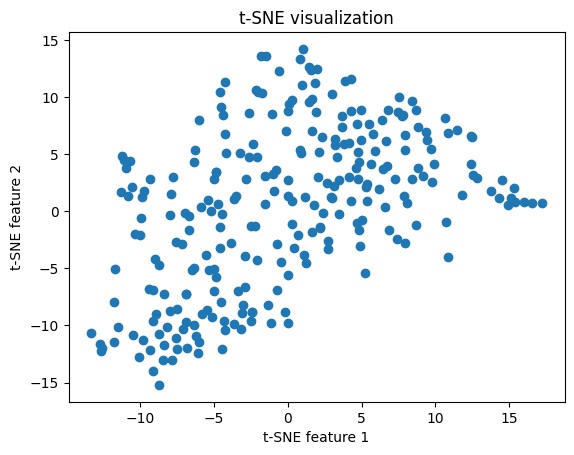

In [43]:
#stochastic neighbor embedding
tsne = TSNE(random_state=42)
tsne_res = tsne.fit_transform(X)

plt.scatter(tsne_res[:, 0], tsne_res[:, 1])
plt.title('t-SNE visualization')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

Some characteristics of the solution.

In [44]:
print("Kullback-Leibler divergence: ",tsne.kl_divergence_)
print("Number of iterations: ",tsne.n_iter_)
print("Learning rate: ",tsne.learning_rate_)

Kullback-Leibler divergence:  0.7446279525756836
Number of iterations:  849
Learning rate:  50.0


It cannot be emphasized enough that considerable experimentation is needed to assess the sensitivity of the results to the various tuning parameters. This is beyond our current scope.

#### Solution characteristics

The t-SNE object created by scikit-learn only contains the Kullback_Leibler divergence as a measure of fit. Alternatives, such as the rank correlation coefficient, can be computed by means of the `dist_corr` function defined above. The two arguments are the original pairwise distance matrix, `dist_matrix` and the coordinates of the embedded points, contained in `tsne_res`.

In [46]:
print("Rank correlation: ",distcorr(dist_matrix,tsne_res))

Rank correlation:  0.6750623071168846


#### Spatializing t-SNE

We can apply the same visualization and spatial analysis of the t-SNE coordinates as illustrated above for MDS. This includes a nearest neighbor match test, HDBScan on the t-SNE coordinates, and an assessment of the common coverage percentage. This is not further pursued here.